In [10]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from datetime import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import plotly.express as px
from SpatialScan.timeseries import *

In [11]:
import tensorflow as tf
from tensorflow import keras

In [14]:
df = pd.read_csv('LondonAprilJune.csv', index_col=False, infer_datetime_format=True, parse_dates=[4, 5])

In [15]:
detector_sample=df["detector_id"].drop_duplicates().sample(10).to_numpy()

In [16]:
start_time = time.time()
Y =count_baseline(df, 15, 1, method="LSTM", detectors=detector_sample)
print(time.time()-start_time)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
94.39338660240173/ 10


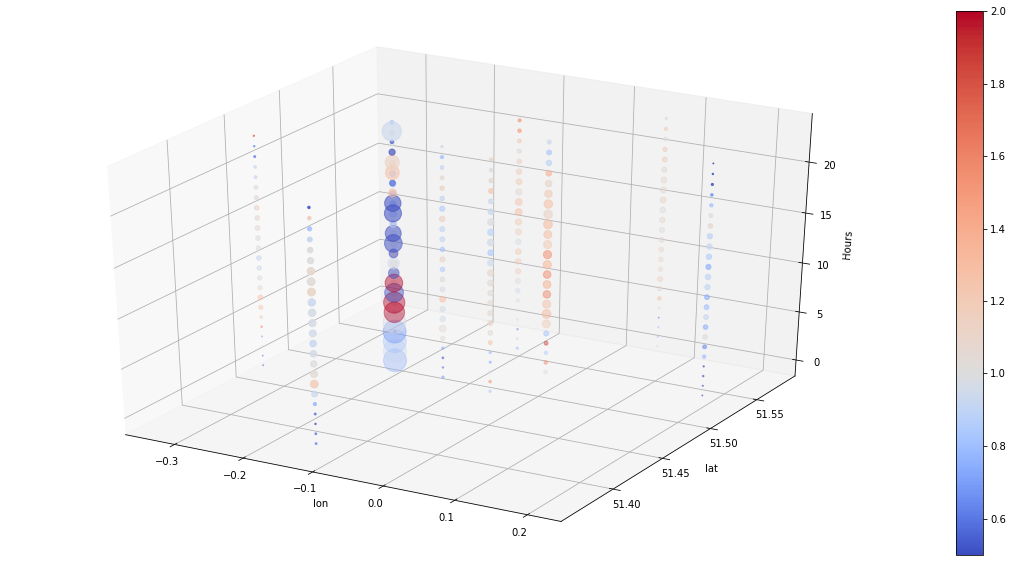

In [17]:
CB_plot(Y)

N11/090r1


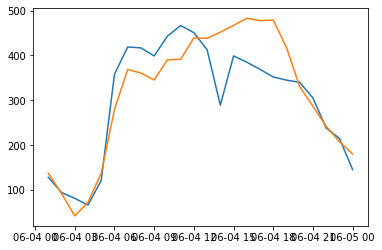

N14/224s2


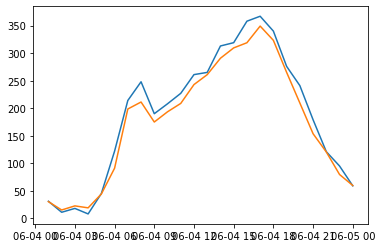

N07/028d1


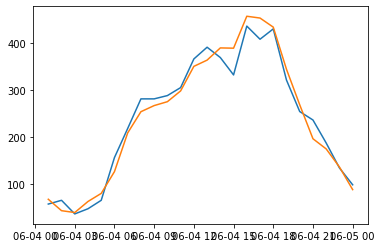

N05/207s1


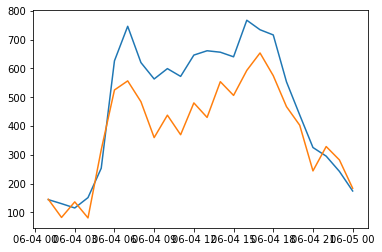

N24/162e1


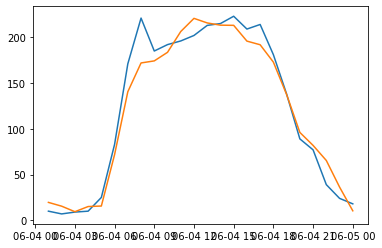

N15/007z1


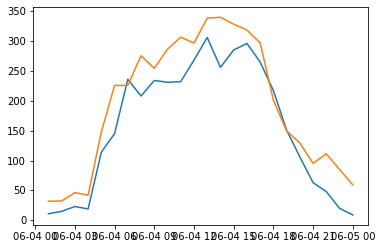

N04/103b1


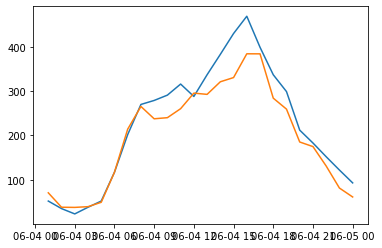

N12/119a1


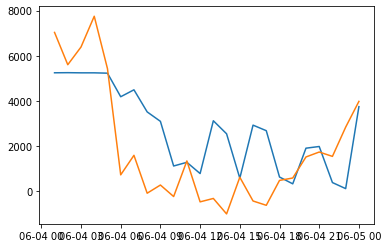

N09/034b2


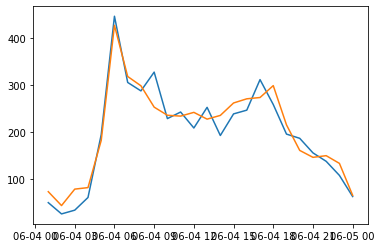

N20/013v1


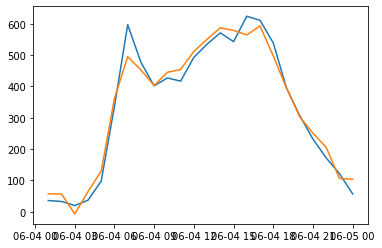

In [18]:
for detector in detector_sample:
    print(detector)
    plt.plot(Y[Y["detector_id"]==detector]["measurement_end_utc"], Y[Y["detector_id"]==detector]["count"])
    plt.plot(Y[Y["detector_id"]==detector]["measurement_end_utc"], Y[Y["detector_id"]==detector]["baseline"])
    plt.show()
        

In [9]:
Y

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,baseline,Unnamed: 0,count,C/B,hour_from_start
0,N27/129a1,-0.379131,51.542269,2020-06-04 00:00:00,2020-06-04 01:00:00,214.539764,14271147.0,140.0,0.652560,0.0
1,N27/129a1,-0.379131,51.542269,2020-06-04 01:00:00,2020-06-04 02:00:00,175.262329,14280316.0,116.0,0.661865,1.0
2,N27/129a1,-0.379131,51.542269,2020-06-04 02:00:00,2020-06-04 03:00:00,163.349808,14290710.0,97.0,0.593818,2.0
3,N27/129a1,-0.379131,51.542269,2020-06-04 03:00:00,2020-06-04 04:00:00,186.363617,14300132.0,109.0,0.584878,3.0
4,N27/129a1,-0.379131,51.542269,2020-06-04 04:00:00,2020-06-04 05:00:00,265.533966,14310581.0,253.0,0.952797,4.0
...,...,...,...,...,...,...,...,...,...,...
235,N22/001b1,-0.192481,51.417047,2020-06-04 19:00:00,2020-06-04 20:00:00,317.022827,14460968.0,323.0,1.018854,19.0
236,N22/001b1,-0.192481,51.417047,2020-06-04 20:00:00,2020-06-04 21:00:00,213.559891,14471267.0,232.0,1.086346,20.0
237,N22/001b1,-0.192481,51.417047,2020-06-04 21:00:00,2020-06-04 22:00:00,208.414612,14481046.0,201.0,0.964424,21.0
238,N22/001b1,-0.192481,51.417047,2020-06-04 22:00:00,2020-06-04 23:00:00,119.741592,14490888.0,117.0,0.977104,22.0


In [43]:
df[df["detector_id"]=="N21/018a1"][df[df["detector_id"]=="N21/018a1"]["measurement_end_utc"]<"2020-05-15 17:00:00"]

,Unnamed: 0,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval
995,2491,N21/018a1,-0.243979,51.380043,2020-04-05 00:00:00,2020-04-05 01:00:00,24
3754,12238,N21/018a1,-0.243979,51.380043,2020-04-05 01:00:00,2020-04-05 02:00:00,16
6456,22209,N21/018a1,-0.243979,51.380043,2020-04-05 02:00:00,2020-04-05 03:00:00,14
9177,31881,N21/018a1,-0.243979,51.380043,2020-04-05 03:00:00,2020-04-05 04:00:00,7
11712,41097,N21/018a1,-0.243979,51.380043,2020-04-05 04:00:00,2020-04-05 05:00:00,23
...,...,...,...,...,...,...,...
177971,639070,N21/018a1,-0.243979,51.380043,2020-04-07 18:00:00,2020-04-07 19:00:00,277
180720,648715,N21/018a1,-0.243979,51.380043,2020-04-07 19:00:00,2020-04-07 20:00:00,70
183128,658264,N21/018a1,-0.243979,51.380043,2020-04-07 20:00:00,2020-04-07 21:00:00,0
185075,665889,N21/018a1,-0.243979,51.380043,2020-04-07 21:00:00,2020-04-07 22:00:00,3
